# Homework 1 

By Claudio Palmeri (N°2062671), Marco Uderzo (N°2096998), Francesco Vo (N°2079413)

The goal of this homework is to apply 3 different function minimization algorithms (Gradient Descent, Gauss-Southwell BCGD, Randomized BCGD) to a binary classification task.  

We will use semisupervised learning which will be applied to both a made up 2D dataset and a publicly available dataset.

In [86]:
#Firstly we will import all the necessary libraries and define some useful parameters:
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import pandas as pd
from sklearn.datasets import make_blobs
import time

DATA_DIM = 5000 # number of data points
N_FEATURES = 2 # number of features
P_LABLP = 0.025 # percentage of examples with label 1
P_LABLN = 0.025 # percentage of examples with label -1
MAX_ITERS = 100 # maximum number of iterations GD
BCGD_MAX_ITERS = 100000 # maximum number of iterations BCGD
EPS = 1e-6 # thresholds for stopping condition
n = DATA_DIM
n_lablP = int(n * P_LABLP) # Number of examples (with label +1) that will be used as a given by our model.
n_lablN = int(n * P_LABLN) # Number of examples (with label -1) that will be used as a given by our model.

Here are defined all the methods that we used:

In [87]:
# Choose which labels to keep as given in the made up dataset:
def assign_labels(data_dim, n_labl, label, prng):
    y = np.zeros((data_dim,), int)
    i = 0
    
    while i < n_labl:
        idx = prng.randint(low=0, high=data_dim)
        if y[idx] == 0:
            y[idx] = label
            i += 1
    return y

# Plot our made up dataset while differentiating between the 3 possible labels: 1,0,-1
def plot_data(data, y):
    cdict = {0: "lightgrey", 1: "#619CFF", -1: "#F8766D"}

    _, ax = plt.subplots()
    for g in [0, 1, -1]:
        ix = np.where(y == g)
        ax.scatter(data[ix, 0], data[ix, 1], c=cdict[g], label=g)
    ax.legend()
    plt.show()

# Create 2 boolean masks capable of differenciating between labeled and unlabaled examples:
def generate_mask(lidx):
    # lidx: list of index of labelled examples
    umask = np.ones(y.shape, dtype=bool)
    umask[lidx] = False

    lmask = np.zeros(y.shape, dtype=bool)
    lmask[lidx] = True
    return (lmask, umask)

# Calculate the overall value of the loss function value (that we have to to minimize):
def calculate_loss(W, y, lidx):
    n = W.shape[0]
    loss = 0
    
    [lm, um] = generate_mask(lidx)

    L = np.zeros((n, n))

    v = np.outer(y, np.ones(n))
    dd = (v - v.T) ** 2

    L = np.multiply(W, dd)

    loss += np.sum(L[:,lm]) + 0.5 * np.sum(L[:,um])
    return loss

# We compute here our random starting point:
def yinit(y, lidx, rs):
    prng = np.random.RandomState(rs)
    (_, um) = generate_mask(lidx)
    labels = [-1, 1]

    ystart = np.copy(y)

    for i in range(n):
        if um[i] == True:
            idx = prng.randint(low=0, high=2)
            ystart[i] = labels[idx]

    return ystart

# We calculate our fixed stepsize here:
def calculate_stepsize(W):
    Lapl = np.diag(np.sum(W, axis=1)) - W
    H = Lapl + np.eye(n)

    lvalue = scipy.linalg.eigh(H, subset_by_index=(n-1, n-1))[0][0]
    # sigma = scipy.linalg.eigh(H, subset_by_index=(0,0))[0][0] 

    return 1/lvalue

# We calculate the gradient of the loss function here:
def calculate_gradient(W, y, lidx):
    n = W.shape[0]
    grd = np.zeros(n)
    (lm, um) = generate_mask(lidx)

    L = np.ones((n,n))

    v = np.outer(y, np.ones(n))
    dd = (v - v.T)

    L = np.multiply(W, dd)
    
    L[:,lm] *= 2
    L[:,um] *= 1

    grd[um] =  np.sum(L[um,:], axis=1)
    return grd

# We compute the final guess here:
def get_result(x, y_init):
    y_hat = np.copy(y_init)

    for i in range(n):
        if x[i] > 0:
            y_hat[i] = 1
        else:
            y_hat[i] = -1
    return y_hat

# We plot the overall evolution of a metric during the application of our algorithms:
def plot_metric(acc, iter):
    x_axis = np.arange(1, iter+1, 1)

    plt.plot(x_axis, acc[0:iter])
    plt.grid()
    plt.show()

def plot_metric_dataset(x, y, iter):

    plt.plot(x[0:iter], y[0:iter])
    plt.grid()
    plt.show()


# In the two BCGD algorithms we don't need to compute the gradient each time, we can just update it with this function:
def update_gradient(grad, x, W, lidx, idx, x_old):
    n = W.shape[0]
    (lm, _) = generate_mask(lidx)
    
    xi = x[idx]
    dd = xi * np.ones(n) - x
    L = np.multiply(dd, W[idx, :])
    L[lm] *= 2
    
    grad[idx] = np.sum(L)

    # update all the other gradients
    dn = x - xi * np.ones(n)
    do = x - x_old * np.ones(n)
    Lt = np.multiply(dn, W[:,idx]) - np.multiply(do, W[:,idx])
    Lt[lm] = 0
    Lt[idx] = 0
    grad += Lt
    return grad

# We calculate the contribution that x[idx] gives to the overall loss function i.e. only the terms of the summatory that depends on it:
def single_loss(W, x, lidx, idx):
    n = W.shape[0]
    (lm, um) = generate_mask(lidx)
    
    xi = x[idx]
    dd = (xi * np.ones(n) - x) ** 2
    L1 = np.multiply(dd, W[idx, :])
    L2 = np.multiply(dd, W[:, idx])

    single_loss = np.sum(L1[lm]) + 0.5 * np.sum(L1[um])
    single_loss += 0.5 * np.sum(L2)
    return single_loss

# We compute accuracy,precision and recall for our classification:
def metrics(heart,y,uidx):
  TP=0
  TN=0
  FN=0
  FP=0
  for i in uidx[0]:
    if heart[i]==1 and y[i]>0:
      TP+=1
    elif heart[i]==1 and y[i]<0:
      FN+=1
    elif heart[i]==-1 and y[i]>0:
      FP+=1
    elif heart[i]==-1 and y[i]<0:
      TN+=1

  ACC=(TP+TN)/(TP+TN+FN+FP)
  PRE=(TP)/(TP+FP)
  REC=(TP)/(TP+FN)
  return ACC,PRE,REC

We can create now our made up 2D dataset by applying the make_blobs method 2 times.

In [88]:
prng = np.random.RandomState(42)

rnd1 = np.random.seed(42)
rnd2 = np.random.seed(123)
data1, b1 = make_blobs(n_samples=int(n/2), n_features=N_FEATURES, centers=1, cluster_std=2, random_state=rnd1)
data2, b2 = make_blobs(n_samples=int(n/2), n_features=N_FEATURES, centers=1, cluster_std=2, random_state=rnd2)

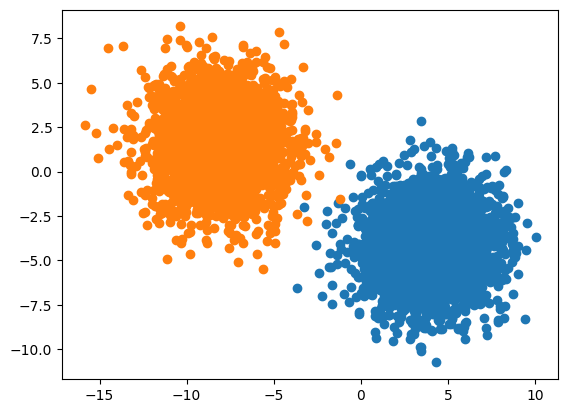

In [89]:
#Here is a plot of our dataset:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(data1[:,0], data1[:,1])
ax.scatter(data2[:,0], data2[:,1])
plt.show()

In [90]:
# We keep as a given label only a small percentage of examples from both labels:
y1 = assign_labels(int(n/2), n_lablP, 1, prng)
y2 = assign_labels(int(n/2), n_lablN, -1, prng)

# We merge here the 2 blobs:
data = np.concatenate((data1, data2), axis=0)
y = np.concatenate((y1, y2), axis=0)

# We keep track of which are the labeled/unlabeled examples:
lidx = np.where((y == 1) | (y == -1))
uidx = np.where(y==0)

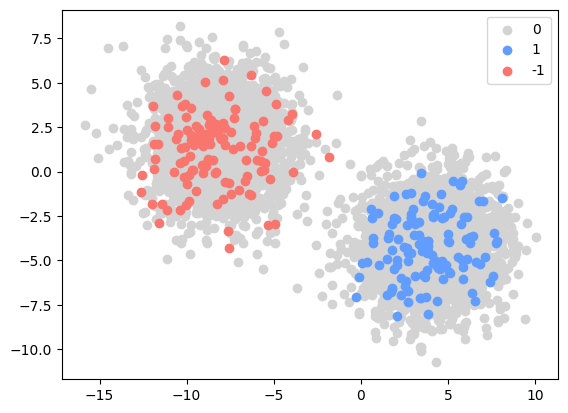

In [91]:
#Here are the results of our label's assignment:
plot_data(data, y)

In [92]:
# We create now the weight matrix by using the gaussian norm of the difference between each pair of examples:
dvar = np.var(data)

W = np.zeros((n, n))

'''
Slower but equivalent code to the one used below:
for i in range(n):
    for j in range(n):
        W[i,j] = np.exp(-(np.linalg.norm((data[i,:] - data[j,:]), 2) ** 2) / (2 * dvar))
'''

dd = 0

for i in range(N_FEATURES):
    vv = data[:,i]
    tt = np.outer(vv, np.ones(n))
    dd += (tt - tt.T) ** 2

W = np.exp(-np.divide(dd, 2*dvar))

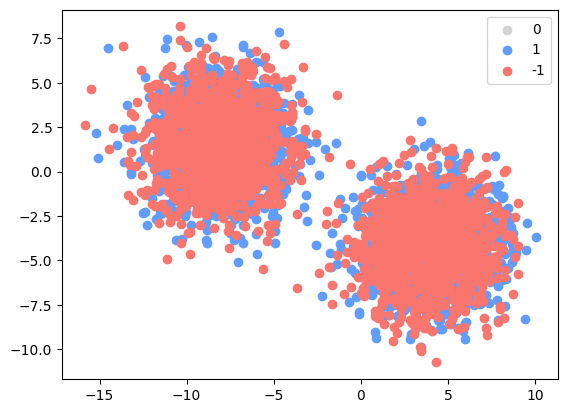

10828653.336027116

In [93]:
(lm, um) = generate_mask(lidx)
ystart = yinit(y, lidx, 42)

#The plot below is our initial random guess, we will start from this point when applying our minimization algorithms:

plot_data(data, ystart)
calculate_loss(W, ystart, lidx)

In [94]:
# Lastly we calculate the appropriate stepsize:
alpha = calculate_stepsize(W)
print(f"alpha = {alpha}\n")

alpha = 0.00043110897401518717



## GRADIENT DESCENT

In [95]:
#We apply here the Gradient Descent algorithm:

loss_history = np.zeros(MAX_ITERS)
time = np.zeros(MAX_ITERS)
s_iter = 0

pp = np.copy(ystart)
pp = pp.astype("float64")

loss = calculate_loss(W, pp, lidx)
prev_loss = 0

for iter in range(MAX_ITERS):
    s_iter = iter
    grad = calculate_gradient(W, pp, lidx)
    pp -= alpha*grad
    
    prev_loss = loss
    loss = calculate_loss(W, pp, lidx)
    loss_history[iter] = loss
    
    rel_loss = np.abs(loss - prev_loss)/prev_loss
    if rel_loss < EPS:
        break;
    
    print(f"step\t{iter+1}:\t{loss}")
    

step	1:	790889.9762175729
step	2:	621097.3823949371
step	3:	575857.6817283903
step	4:	552041.81155638
step	5:	538356.9991729077
step	6:	530647.6808433664
step	7:	526574.6161317202
step	8:	524694.1879081179
step	9:	524102.22992641444
step	10:	524234.99269557267
step	11:	524745.4382575415
step	12:	525424.2047662478
step	13:	526148.7947301295
step	14:	526850.9286067644
step	15:	527495.6491208728
step	16:	528068.0288874512
step	17:	528564.7878668322
step	18:	528989.0699278754
step	19:	529347.2416082988
step	20:	529646.9763063679
step	21:	529896.1479399424
step	22:	530102.2278987962
step	23:	530271.9894456796
step	24:	530411.3952241915
step	25:	530525.5897084025
step	26:	530618.9481139818
step	27:	530695.152259798
step	28:	530757.2758957926
step	29:	530807.8695589795
step	30:	530849.0396873415
step	31:	530882.5195520953
step	32:	530909.7312365199
step	33:	530931.838828999
step	34:	530949.7934881607
step	35:	530964.3712569107
step	36:	530976.2045622017
step	37:	530985.8083087644
step	38:	530

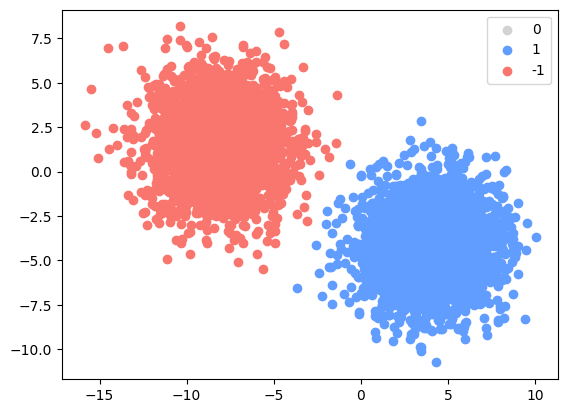

In [96]:
# We can plot the final guess here:
y_hat = get_result(pp, ystart)
plot_data(data, y_hat)

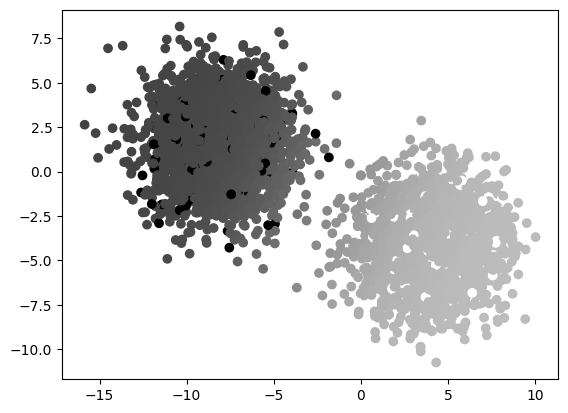

In [97]:
#We can show here the degree of confidence that the algorithm has in each example in its own classification:
plt.scatter(data[:,0], data[:,1], c=pp, cmap="gray")
plt.show()

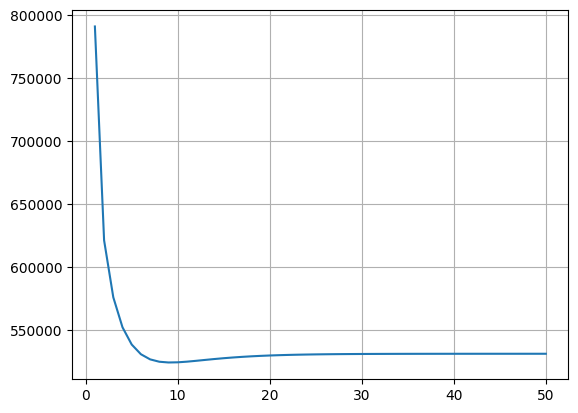

In [98]:
plot_metric(loss_history, s_iter)

## GAUSS-SOUTHWELL BCGD

In [99]:
ystart = yinit(y, lidx, 42)
x = np.copy(ystart)
x = x.astype("float64")

grad = calculate_gradient(W, x, lidx)
loss = calculate_loss(W, x, lidx)
loss_history = np.zeros(BCGD_MAX_ITERS)

s_iter = 0

for iter in range(BCGD_MAX_ITERS):
    s_iter = iter
    loss_old = 0
    loss_new = 0
    x_old = 0
    
    idx = np.argmax(np.abs(grad))
    loss_old = single_loss(W, x, lidx, idx)
    x_old = x[idx]

    x[idx] -= alpha * grad[idx]
    loss_new = single_loss(W, x, lidx, idx)

    grad = update_gradient(grad, x, W, lidx, idx, x_old)
    prev_loss = loss
    loss = loss - loss_old + loss_new
    loss_history[iter] = loss

    rel_loss = np.abs(loss - prev_loss)/prev_loss * DATA_DIM

    if rel_loss < EPS:
        break;
    
    print(f"step\t{iter+1}:\t{loss}")

Output streaming troncato alle ultime 5000 righe.
step	22204:	567503.1451368991
step	22205:	567498.679136248
step	22206:	567493.9100357321
step	22207:	567489.5341344805
step	22208:	567484.6116070132
step	22209:	567480.2597633323
step	22210:	567475.370008624
step	22211:	567471.1046204626
step	22212:	567466.7291596117
step	22213:	567462.2787639142
step	22214:	567457.924109051
step	22215:	567453.4579552677
step	22216:	567448.0445170619
step	22217:	567443.0568861796
step	22218:	567438.634841444
step	22219:	567434.2644666318
step	22220:	567429.8566986256
step	22221:	567425.4426671136
step	22222:	567420.6992379013
step	22223:	567419.864395455
step	22224:	567419.1078859827
step	22225:	567418.3901041346
step	22226:	567417.9579031224
step	22227:	567417.6113280167
step	22228:	567416.4522583635
step	22229:	567415.9177961703
step	22230:	567415.3673699687
step	22231:	567415.0076465022
step	22232:	567413.4775784397
step	22233:	567408.8177159254
step	22234:	567408.2927426014
step	22235:	567403.951210

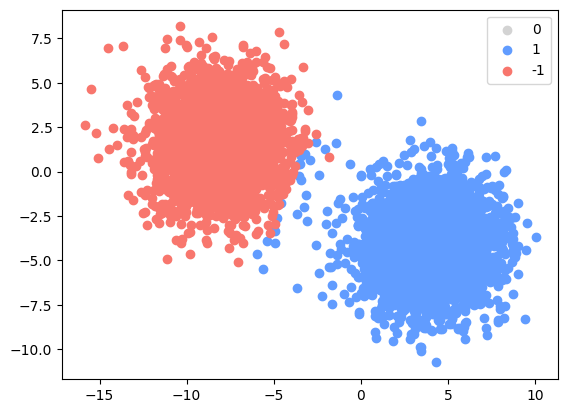

In [100]:
y_hat = get_result(x, ystart)
plot_data(data, y_hat)

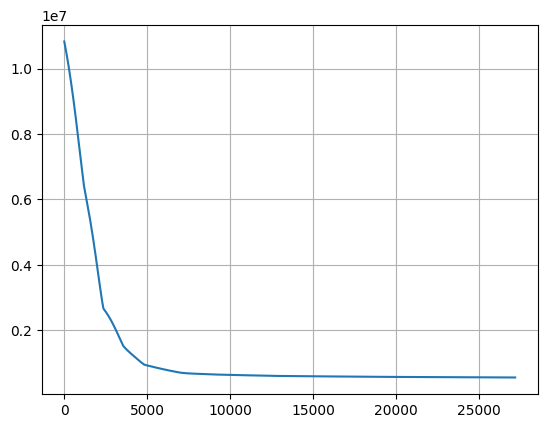

In [101]:
plot_metric(loss_history, iter)

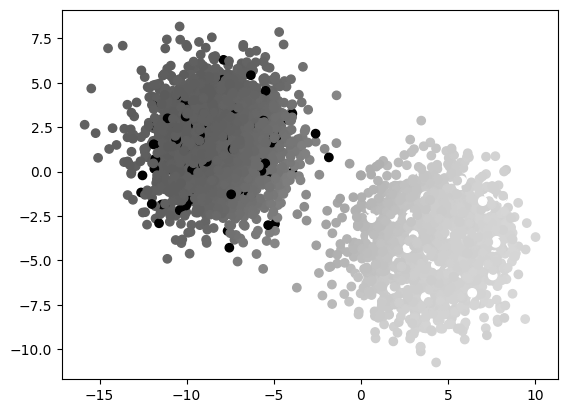

556439.8052010942

In [102]:
plt.scatter(data[:,0], data[:,1], c=x, cmap="gray")
plt.show()

calculate_loss(W, x, lidx)

## RANDOMIZED BCGD

In [103]:
ystart = yinit(y, lidx, 42)
x = np.copy(ystart)
x = x.astype("float64")

grad = calculate_gradient(W, x, lidx)
loss = calculate_loss(W, x, lidx)
loss_history = np.zeros(BCGD_MAX_ITERS)

s_iter = 0

for iter in range(BCGD_MAX_ITERS):
    s_iter = iter
    loss_old = 0
    loss_new = 0
    x_old = 0
    
    idx = np.random.choice(uidx[0], 1)
    idx = idx[0]
    loss_old = single_loss(W, x, lidx, idx)
    x_old = x[idx]

    x[idx] -= alpha * grad[idx]
    loss_new = single_loss(W, x, lidx, idx)

    grad = update_gradient(grad, x, W, lidx, idx, x_old)
    prev_loss = loss
    loss = loss - loss_old + loss_new
    loss_history[iter] = loss

    rel_loss = np.abs(loss - prev_loss)/prev_loss * DATA_DIM

    if rel_loss < EPS*0.01:
        break;
    
    print(f"step\t{iter+1}:\t{loss}")

Output streaming troncato alle ultime 5000 righe.
step	95001:	529079.6107300023
step	95002:	529079.7224201486
step	95003:	529079.7504092378
step	95004:	529079.7772712444
step	95005:	529079.900433208
step	95006:	529079.9361872629
step	95007:	529079.9757083048
step	95008:	529079.9843817103
step	95009:	529079.9992944365
step	95010:	529080.1410829603
step	95011:	529080.188354943
step	95012:	529080.410438826
step	95013:	529080.4438404446
step	95014:	529080.4524617185
step	95015:	529080.5010035597
step	95016:	529080.5396491232
step	95017:	529080.669714111
step	95018:	529080.7143362095
step	95019:	529080.7566028048
step	95020:	529080.823916765
step	95021:	529080.908620147
step	95022:	529080.9577927599
step	95023:	529080.9856566663
step	95024:	529081.0757097413
step	95025:	529081.1023484323
step	95026:	529081.1892302694
step	95027:	529081.2100109606
step	95028:	529081.3490975719
step	95029:	529081.4519573012
step	95030:	529081.4711868867
step	95031:	529081.5159116255
step	95032:	529081.6458341

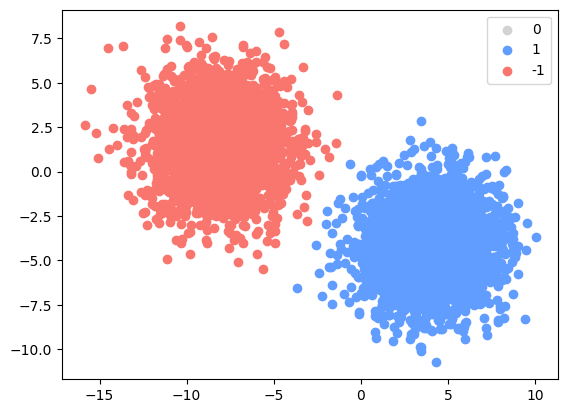

In [104]:
y_hat = get_result(x, ystart)
plot_data(data, y_hat)

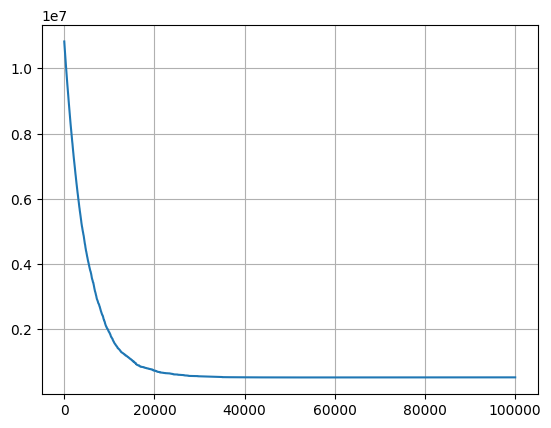

In [105]:
plot_metric(loss_history, iter)

## Publicly available dataset

### Preparation of our dataset

We found [here](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) a dataset pertaining heart diseases.  
More information can be found in the pdf of our report.

In [106]:
#Firstly we can import the dataset:
import pandas as pd
import numpy as np
dataset = pd.read_csv('/content/sample_data/hearts.csv')

In [107]:
#Feature preparation:

# We drop the label ("HeartDiseases" column) in order to have a dataframe containing only the features  
data = dataset.drop('HeartDisease', axis=1)
#Convert to numpy matrix
data=data.to_numpy()

#The value 0 in the 5 numerical variables should be interpreted as an N/A, thus we substitute it with the overall median value for that feature.
#(Better alternative than the mean since it is less influenced by outliers)
#We also normalize each feature by dividing them by the maximum value that the aformentioned feature takes in the dataset.

median=np.median(data[:,[0,3,4,7,9]],axis=0)
maxx=np.max(data[:,[0,3,4,7,9]],axis=0)
print(median)
for idx,col in enumerate([0,3,4,7,9]):
  for row in range(918):
    if data[row,col]==0:
      data[row,col]=median[idx]
    data[row,col]=data[row,col]/maxx[idx]

#There are also 5 categorical variables: in order to use them in our algorithm we applied "one hot encoding" to them.
sex=np.zeros((918,2))
pain=np.zeros((918,4))
fasting=np.zeros((918,2))
resting=np.zeros((918,3))
exercize=np.zeros((918,2))
st=np.zeros((918,3))
for i in range(918):
  if data[i,1]=='M':
    sex[i,0]=1
  else:
    sex[i,1]=1
  
  if data[i,2]=='TA':
    pain[i,0]=1
  elif data[i,2]=='ATA':
    pain[i,1]=1
  elif data[i,2]=='NAP':
    pain[i,2]=1
  elif data[i,2]=='ASY':
    pain[i,3]=1

  if data[i,5]=='1':
    fasting[i,0]=1
  else:
    fasting[i,1]=1

  if data[i,6]=='ST':
    resting[i,0]=1
  elif data[i,6]=='Normal':
    resting[i,1]=1
  elif data[i,6]=='LVH':
    resting[i,2]=1

  if data[i,8]=='Y':
    exercize[i,0]=1
  else:
    exercize[i,1]=1

  if data[i,10]=='Up':
    st[i,0]=1
  elif data[i,10]=='Flat':
    st[i,1]=1
  elif data[i,10]=='Down':
    st[i,2]=1

data=np.delete(data,[False,True,True,False,False,True,True,False,True,False,True],1)
data=np.concatenate((data,sex,pain,fasting,resting,exercize,st),axis=1)

[54.0 130.0 223.0 138.0 0.6]


In [108]:
#Label preparation:

# We store the label column and randomly choose from it which ones to keep as a given to our algorithms:
heart=dataset['HeartDisease']
heart=heart.to_numpy()
y=np.zeros(len(heart))
for i in range(len(heart)):
  k=np.random.uniform(0,1,1)
  if heart[i]==0:
    heart[i]=-1 #The original dataset has 0 and 1 as labels, we want -1 and 1.
  if k<P_LABLP and heart[i]==1:  
    y[i] = 1
  elif k<P_LABLN and heart[i]==-1:
    y[i] = -1

### Algorithm application

In [109]:
DATA_DIM = 918 # number of data points
N_FEATURES = 21 # number of features
n = DATA_DIM
MAX_ITERS=300

lidx = np.where((y == 1) | (y == -1))
uidx = np.where(y==0)

In [110]:
# I create the weight matrix here:

dvar = np.var(data)

W = np.zeros((n, n))


for i in range(n):
    for j in range(n):
        W[i,j] = np.exp(-(np.linalg.norm((data[i,:] - data[j,:]), 2) ** 2) / (2 * dvar))


In [111]:
(lm, um) = generate_mask(lidx)

# we generate randomly our first guess
ystart = yinit(y, lidx, 42)

In [112]:
# We calculate the appropriate stepsize
alpha = calculate_stepsize(W)
print(f"alpha = {alpha}\n")

alpha = 0.010457369266348002



**Gradient descent**

In [113]:
import time

In [114]:
loss_history = np.zeros(MAX_ITERS)
accuracy_history=np.zeros(MAX_ITERS)
precision_history=np.zeros(MAX_ITERS)
recall_history=np.zeros(MAX_ITERS)
time_history=np.zeros(MAX_ITERS)
start = time.time()
s_iter = 0
pp = np.copy(ystart) 
pp = pp.astype("float64")

loss = calculate_loss(W, pp, lidx)
prev_loss = 0

for iter in range(MAX_ITERS):
    s_iter = iter
    grad = calculate_gradient(W, pp, lidx)
    pp -= alpha*grad
    
    prev_loss = loss
    loss = calculate_loss(W, pp, lidx)
    loss_history[iter] = loss
    accuracy_history[iter],precision_history[iter],recall_history[iter]=metrics(heart,pp,uidx)
    rel_loss = np.abs(loss - prev_loss)/prev_loss
    end = time.time()
    time_history[iter] = end - start
    if rel_loss < EPS:
        break;
    
    print(f"step\t{iter+1}:\t{loss}")
    

step	1:	7541.391937772369
step	2:	4316.264791652621
step	3:	3017.24577696651
step	4:	2349.904993435
step	5:	1943.606335336275
step	6:	1666.0103610814572
step	7:	1461.9574768112852
step	8:	1304.9289256796178
step	9:	1180.4185595584966
step	10:	1079.598126662725
step	11:	996.6463398279774
step	12:	927.5016455160599
step	13:	869.2181171398122
step	14:	819.6005179470374
step	15:	776.9806736181151
step	16:	740.0717445522114
step	17:	707.8688141250509
step	18:	679.5787845408236
step	19:	654.5697383427048
step	20:	632.333706433589
step	21:	612.4589196321353
step	22:	594.6089024843461
step	23:	578.5065776350611
step	24:	563.9220821235849
step	25:	550.663359493517
step	26:	538.5688443079471
step	27:	527.5017351226317
step	28:	517.3454812393304
step	29:	508.00020270642756
step	30:	499.37983220252625
step	31:	491.40981862730143
step	32:	484.0252703438544
step	33:	477.16944456384294
step	34:	470.79251085592466
step	35:	464.8505330146219
step	36:	459.30462588414673
step	37:	454.1202531701256
step	3

In [115]:
result=metrics(heart,pp,uidx)
print(result)

(0.7952488687782805, 0.7828467153284672, 0.8737270875763747)


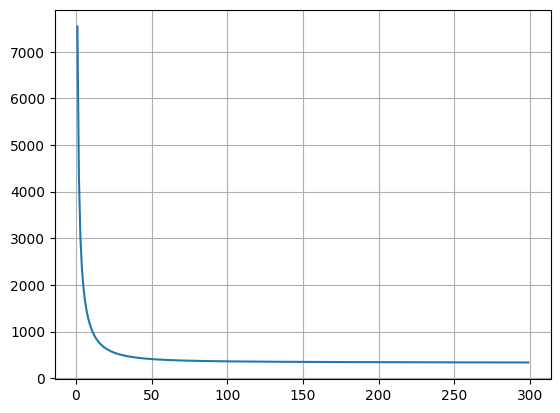

In [116]:
plot_metric(loss_history, s_iter)



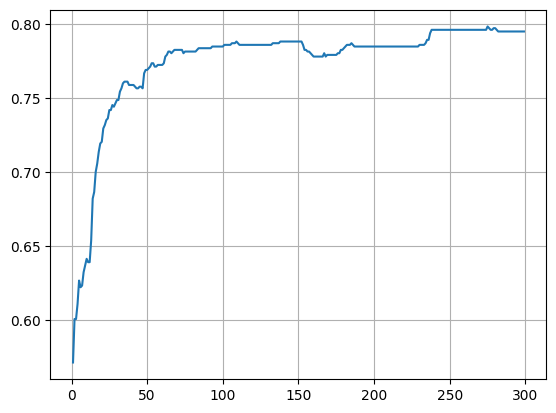

In [117]:
plot_metric(accuracy_history, s_iter)


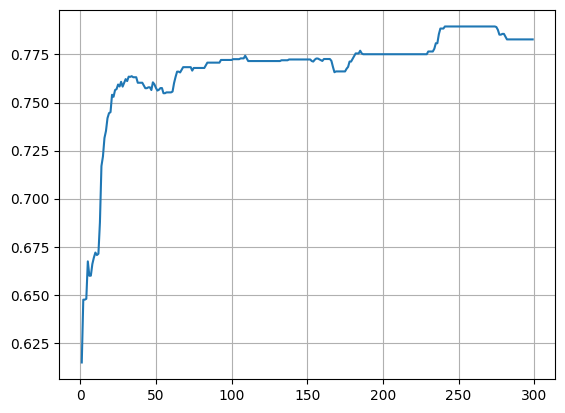

In [118]:
plot_metric(precision_history, s_iter)


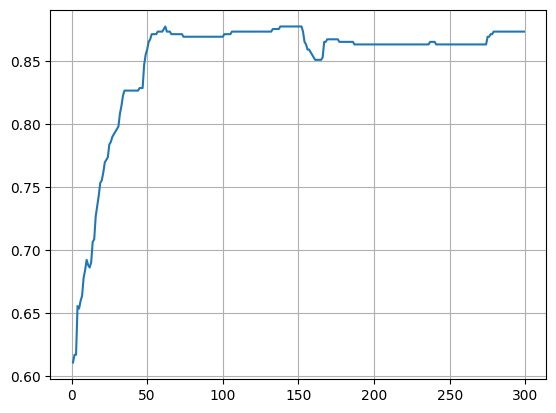

In [119]:
plot_metric(recall_history, s_iter)

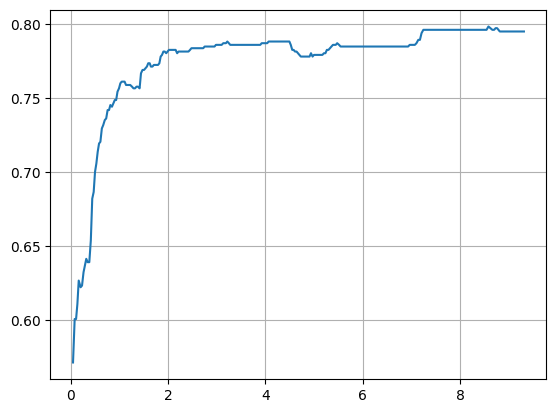

In [120]:
plot_metric_dataset(time_history,accuracy_history,s_iter)

**GAUSS-SOUTHWELL BCGD**

In [121]:
ystart = yinit(y, lidx, 42)
x = np.copy(ystart)
x = x.astype("float64")

grad = calculate_gradient(W, x, lidx)
loss = calculate_loss(W, x, lidx)
loss_history = np.zeros(BCGD_MAX_ITERS)
accuracy_history=np.zeros(BCGD_MAX_ITERS)
precision_history=np.zeros(BCGD_MAX_ITERS)
recall_history=np.zeros(BCGD_MAX_ITERS)
time_history=np.zeros(BCGD_MAX_ITERS)
start = time.time()
s_iter = 0

for iter in range(BCGD_MAX_ITERS):
    s_iter = iter
    loss_old = 0
    loss_new = 0
    x_old = 0
    
    idx = np.argmax(np.abs(grad))
    loss_old = single_loss(W, x, lidx, idx)
    x_old = x[idx]

    x[idx] -= alpha * grad[idx]
    loss_new = single_loss(W, x, lidx, idx)

    grad = update_gradient(grad, x, W, lidx, idx, x_old)
    prev_loss = loss
    loss = loss - loss_old + loss_new
    loss_history[iter] = loss
    accuracy_history[iter],precision_history[iter],recall_history[iter]=metrics(heart,x,uidx)
    end = time.time()
    time_history[iter] = end - start
    rel_loss = np.abs(loss - prev_loss)/prev_loss * DATA_DIM

    if rel_loss < EPS:
        break;
    
    print(f"step\t{iter+1}:\t{loss}")

Output streaming troncato alle ultime 5000 righe.
step	63147:	341.06360298592426
step	63148:	341.0632341340505
step	63149:	341.06283338205156
step	63150:	341.0624661204586
step	63151:	341.0620964232471
step	63152:	341.061724884834
step	63153:	341.0613616167866
step	63154:	341.0610099796968
step	63155:	341.0606481887478
step	63156:	341.0602937299642
step	63157:	341.0599446048962
step	63158:	341.0595940034054
step	63159:	341.0592422847411
step	63160:	341.05889285702443
step	63161:	341.05855344060865
step	63162:	341.05822783080964
step	63163:	341.05784990460677
step	63164:	341.0575102741451
step	63165:	341.0571415635825
step	63166:	341.0567689388539
step	63167:	341.0563960375869
step	63168:	341.05601643289884
step	63169:	341.05563628593035
step	63170:	341.0552627481861
step	63171:	341.0549126925402
step	63172:	341.05455627752303
step	63173:	341.05419992607204
step	63174:	341.0538442054504
step	63175:	341.0534946289438
step	63176:	341.0531273094646
step	63177:	341.05275574360786
step	63178

In [122]:
result=metrics(heart,x,uidx)
print(result)

(0.8009049773755657, 0.7797513321492007, 0.8940936863543788)


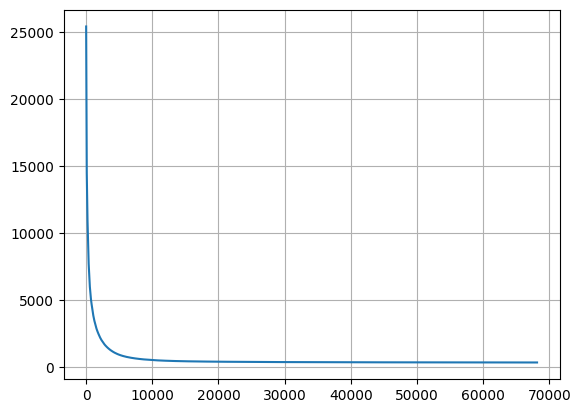

In [123]:
plot_metric(loss_history, s_iter)

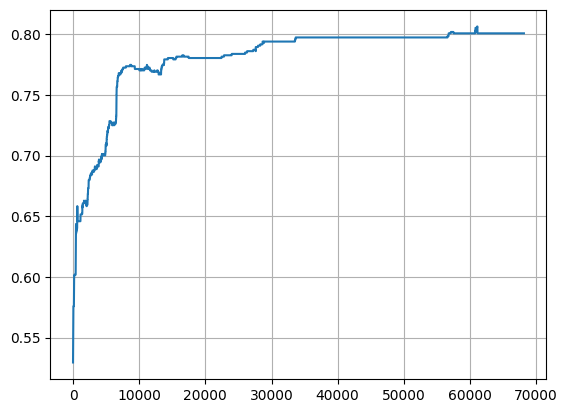

In [124]:
plot_metric(accuracy_history, s_iter)


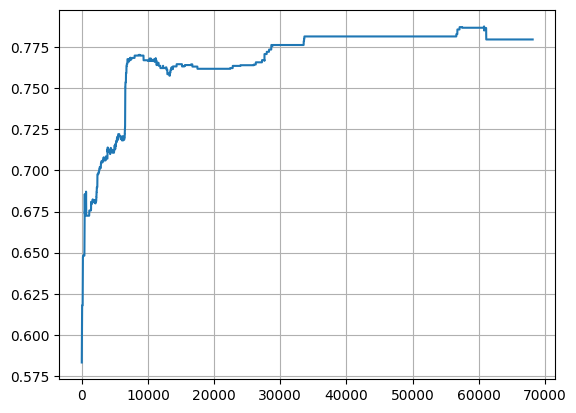

In [125]:
plot_metric(precision_history, s_iter)


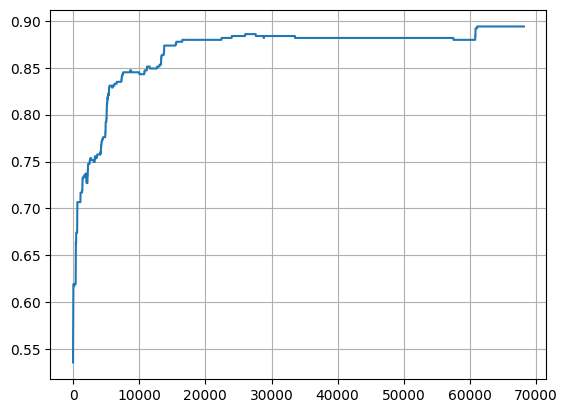

In [126]:
plot_metric(recall_history, s_iter)


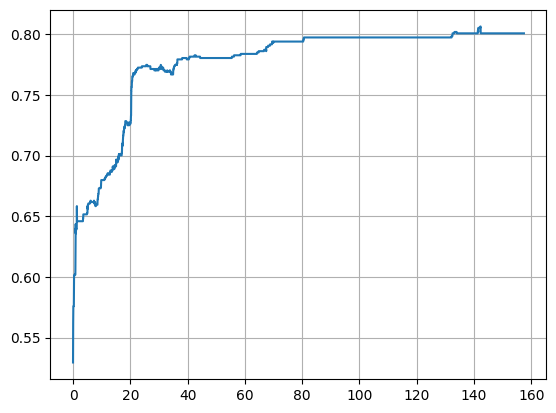

In [127]:
plot_metric_dataset(time_history,accuracy_history,s_iter)

**Randomized BCGD**

In [128]:
ystart = yinit(y, lidx, 42)
x = np.copy(ystart)
x = x.astype("float64")

grad = calculate_gradient(W, x, lidx)
loss = calculate_loss(W, x, lidx)
loss_history = np.zeros(BCGD_MAX_ITERS)
accuracy_history=np.zeros(BCGD_MAX_ITERS)
precision_history=np.zeros(BCGD_MAX_ITERS)
recall_history=np.zeros(BCGD_MAX_ITERS)
time_history=np.zeros(BCGD_MAX_ITERS)
start = time.time()
s_iter = 0

for iter in range(BCGD_MAX_ITERS):
    s_iter = iter
    loss_old = 0
    loss_new = 0
    x_old = 0
    
    idx = np.random.choice(uidx[0], 1)
    idx = idx[0]
    loss_old = single_loss(W, x, lidx, idx)
    x_old = x[idx]

    x[idx] -= alpha * grad[idx]
    loss_new = single_loss(W, x, lidx, idx)

    grad = update_gradient(grad, x, W, lidx, idx, x_old)
    prev_loss = loss
    loss = loss - loss_old + loss_new
    loss_history[iter] = loss
    accuracy_history[iter],precision_history[iter],recall_history[iter]=metrics(heart,x,uidx)
    end = time.time()
    time_history[iter] = end - start
    rel_loss = np.abs(loss - prev_loss)/prev_loss * DATA_DIM

    if rel_loss < EPS*0.001:
        break;
    
    print(f"step\t{iter+1}:\t{loss}")

Output streaming troncato alle ultime 5000 righe.
step	51188:	401.4586113291044
step	51189:	401.45865574126975
step	51190:	401.45569259849657
step	51191:	401.45254573704284
step	51192:	401.44694433564
step	51193:	401.4469358546716
step	51194:	401.4452353979145
step	51195:	401.44541153842505
step	51196:	401.44411153898307
step	51197:	401.4421563655993
step	51198:	401.44241934438736
step	51199:	401.44241889051153
step	51200:	401.4423686712286
step	51201:	401.4426352334103
step	51202:	401.4415633475631
step	51203:	401.43683157945014
step	51204:	401.43205395047835
step	51205:	401.4305321741386
step	51206:	401.4293751656863
step	51207:	401.4270370361106
step	51208:	401.42737220257277
step	51209:	401.4275396391652
step	51210:	401.42747608410684
step	51211:	401.4275193950194
step	51212:	401.42380136549923
step	51213:	401.42116615931957
step	51214:	401.4160304720489
step	51215:	401.4160135618866
step	51216:	401.41628933077027
step	51217:	401.4160429793261
step	51218:	401.4158606279495
step	512

In [129]:
result=metrics(heart,x,uidx)
print(result)

(0.7567873303167421, 0.7536764705882353, 0.835030549898167)


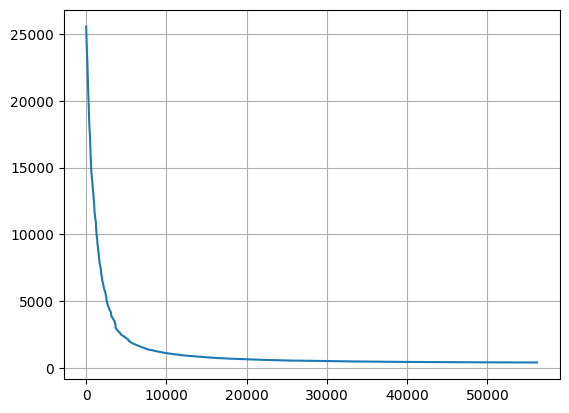

In [130]:
plot_metric(loss_history, s_iter)

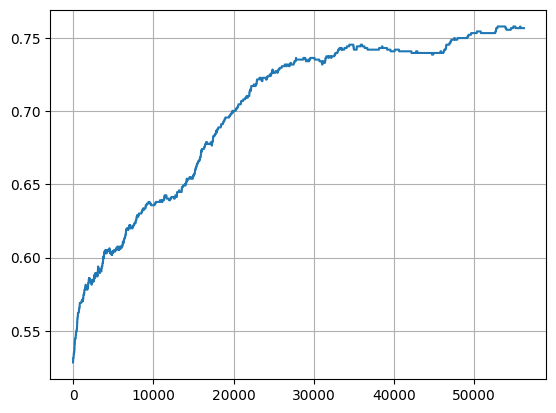

In [131]:
plot_metric(accuracy_history, s_iter)

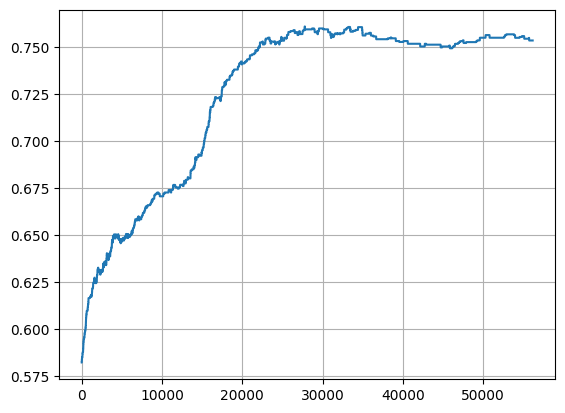

In [132]:
plot_metric(precision_history, s_iter)

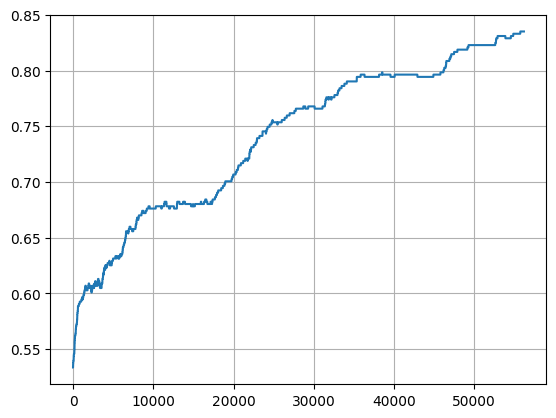

In [133]:
plot_metric(recall_history, s_iter)

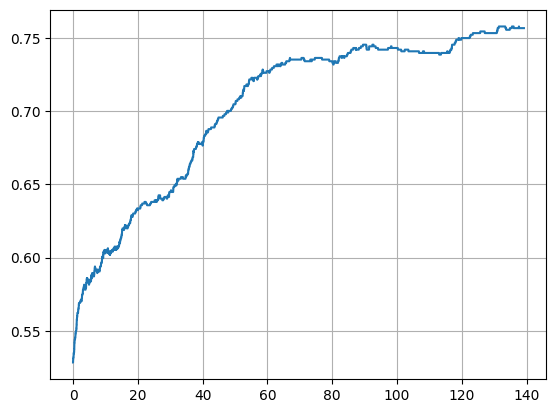

In [134]:
plot_metric_dataset(time_history,accuracy_history,s_iter)